In [1]:
import pandas as pd
from pandas import read_csv
#from patsy import dmatrices
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as sm
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [59]:
#filepath ="C:\Users\Jneny\Desktop\820\datasets\icu_beds.csv"
#dataset = pd.read_csv(filepath, header = 0, sep="," )

data = read_csv(r"C:\Users\Jneny\Desktop\820\datasets\icu_beds.csv", header=0, parse_dates=[0], index_col=0, squeeze=True)
print(type(data))
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 655 entries, 2020-05-01 to 2022-02-14
Data columns (total 10 columns):
adult_icu_crci_patients        655 non-null int64
adult_icu_non_crci_patients    655 non-null int64
available_adult_icu_beds       655 non-null int64
total_adult_icu_patients       655 non-null int64
total_adult_icu_beds           655 non-null int64
ped_icu_crci_patients          655 non-null int64
ped_icu_non_crci_patients      655 non-null int64
available_ped_icu_beds         655 non-null int64
total_ped_icu_patients         655 non-null int64
total_ped_icu_beds             655 non-null int64
dtypes: int64(10)
memory usage: 56.3 KB


,adult_icu_crci_patients,adult_icu_non_crci_patients,available_adult_icu_beds,total_adult_icu_patients,total_adult_icu_beds,ped_icu_crci_patients,ped_icu_non_crci_patients,available_ped_icu_beds,total_ped_icu_patients,total_ped_icu_beds
date,,,,,,,,,,
2020-05-01,244,1154,614,1398,2012,0,51,38,51,89
2020-05-02,236,1210,566,1446,2012,0,56,33,56,89
2020-05-03,246,1211,555,1457,2012,0,54,35,54,89
2020-05-04,243,1197,572,1440,2012,0,56,33,56,89
2020-05-05,243,1252,517,1495,2012,0,59,30,59,89


In [3]:
#check for times when there a provincial shortage of occupancy space when no beds were aviailable
icumax = (data['available_adult_icu_beds'] == 0).sum()
print(icumax)
picumax = (data['available_ped_icu_beds'] == 0).sum()
print(picumax)

0
0


In [60]:
data.describe()

,adult_icu_crci_patients,adult_icu_non_crci_patients,available_adult_icu_beds,total_adult_icu_patients,total_adult_icu_beds,ped_icu_crci_patients,ped_icu_non_crci_patients,available_ped_icu_beds,total_ped_icu_patients,total_ped_icu_beds
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,251.783206,1439.909924,557.796947,1691.693130,2249.490076,1.885496,54.928244,35.532824,56.813740,92.346565
std,204.279555,125.563620,147.217516,127.422515,184.996841,2.787700,8.935175,8.423522,8.847094,3.180678
min,18.000000,1065.000000,320.000000,1398.000000,2012.000000,0.000000,34.000000,8.000000,34.000000,89.000000
25%,114.500000,1357.000000,446.000000,1594.000000,2016.000000,0.000000,48.000000,30.000000,51.000000,89.000000
50%,172.000000,1463.000000,531.000000,1692.000000,2319.000000,1.000000,54.000000,36.000000,56.000000,93.000000
75%,349.500000,1540.500000,632.500000,1772.000000,2356.000000,2.000000,61.000000,41.000000,62.000000,93.000000
max,889.000000,1637.000000,980.000000,2038.000000,2554.000000,13.000000,85.000000,55.000000,85.000000,105.000000


In [4]:
# Will want to focus on patients rather than amount of beds because it will be more useful to know now many are absolutely necessary to set aside for CRCI patients within the ICU, then the amount of total beds needed for all ICU patients. Therefore, main variable of focus will be adult and pediatric CRCI patient numbers. Secondary will be total adult/ped ICU patients
# First part focus is adult CRCI patients

In [15]:
# data.describe(data['adult_icu_crci_patients'])
pd.Series.describe(data) # For a general overview
pd.Series.describe(data['adult_icu_crci_patients'])


count    655.000000
mean     251.783206
std      204.279555
min       18.000000
25%      114.500000
50%      172.000000
75%      349.500000
max      889.000000
Name: adult_icu_crci_patients, dtype: float64

In [17]:
#Data cleaning
#outliers do not really apply to this time series as each recorded observation/ previous counts of crci icu patients are necessary to predict future values.

missing1 = (data['adult_icu_crci_patients'] == 0).sum()
print(missing1)

0


In [26]:
#check for missing observations
data.duplicated(keep='first')

date
2020-05-01    False
2020-05-02    False
2020-05-03    False
2020-05-04    False
2020-05-05    False
              ...  
2022-02-10    False
2022-02-11    False
2022-02-12    False
2022-02-13    False
2022-02-14    False
Length: 655, dtype: bool

In [27]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

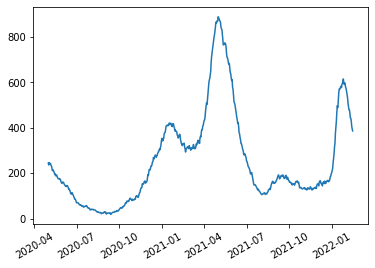

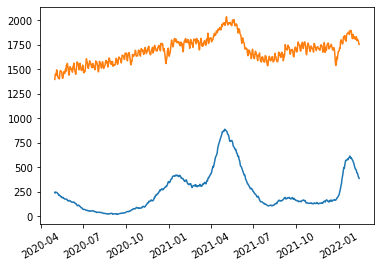

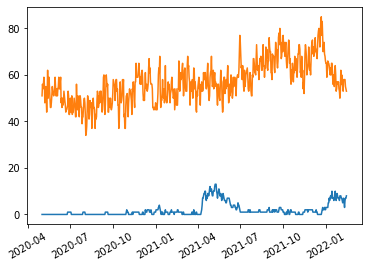

In [29]:
plt.plot(data[0:655]['adult_icu_crci_patients'])
plt.xticks(rotation = 30)
plt.show()

# plt.plot(data[0:655])
# plt.xticks(rotation = 30)
# plt.show()


plt.plot(data.iloc[: , [0, 3]])
plt.xticks(rotation = 30)
plt.show()

plt.plot(data.iloc[: , [5, 8]])
plt.xticks(rotation = 30)
plt.show()

In [7]:
pd.Series.describe(data.iloc[: , [0, 3, 5, 8]])

# newdata = data[['date','adult_icu_crci_patients', 'total_adult_icu_patients', 'ped_icu_crci_patients', 'total_ped_icu_patients']].copy()
# pd.Series.describe(newdata)
# newdata.head(newdata)
# pd.Series.describe(data[1])
# data.head(data['date'])


,adult_icu_crci_patients,total_adult_icu_patients,ped_icu_crci_patients,total_ped_icu_patients
count,655.000000,655.000000,655.000000,655.000000
mean,251.783206,1691.693130,1.885496,56.813740
std,204.279555,127.422515,2.787700,8.847094
min,18.000000,1398.000000,0.000000,34.000000
25%,114.500000,1594.000000,0.000000,51.000000
50%,172.000000,1692.000000,1.000000,56.000000
75%,349.500000,1772.000000,2.000000,62.000000
max,889.000000,2038.000000,13.000000,85.000000


In [8]:
pd.Series.head(data.iloc[: , [0, 3, 5, 8]])

,adult_icu_crci_patients,total_adult_icu_patients,ped_icu_crci_patients,total_ped_icu_patients
date,,,,
2020-05-01,244,1398,0,51
2020-05-02,236,1446,0,56
2020-05-03,246,1457,0,54
2020-05-04,243,1440,0,56
2020-05-05,243,1495,0,59


In [45]:
critpatientdf = (data.iloc[: , [0, 3, 5, 8]])
critpatientdf

,adult_icu_crci_patients,total_adult_icu_patients,ped_icu_crci_patients,total_ped_icu_patients
date,,,,
2020-05-01,244,1398,0,51
2020-05-02,236,1446,0,56
2020-05-03,246,1457,0,54
2020-05-04,243,1440,0,56
2020-05-05,243,1495,0,59
...,...,...,...,...
2022-02-10,442,1809,3,58
2022-02-11,429,1805,6,58
2022-02-12,407,1792,7,55


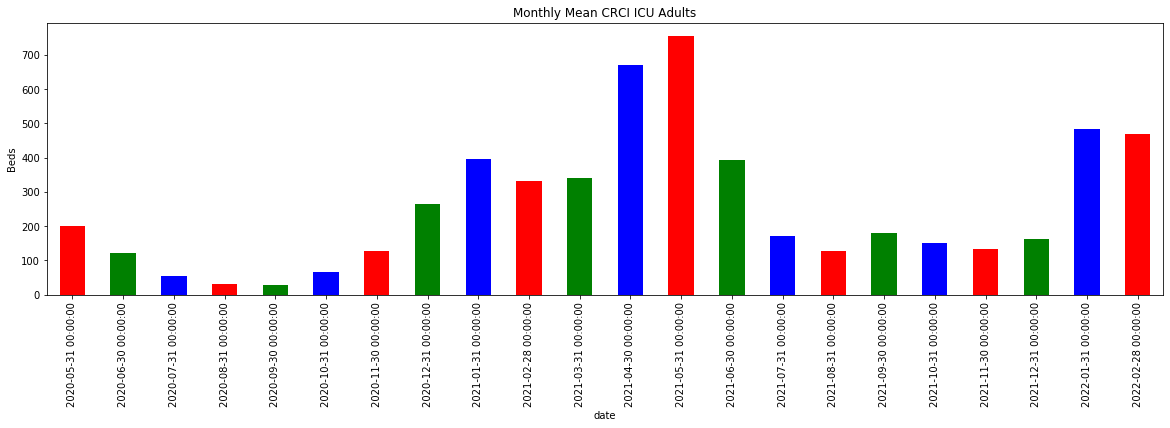

In [79]:
#mean, std per week
critpatientdf.resample(rule = 'w').mean()
critpatientdf['adult_icu_crci_patients'].resample(rule = 'm').mean().plot.bar(color=list('rgb'))
plt.title('Monthly Mean CRCI ICU Adults')
plt.ylabel('Beds')
rcParams['figure.figsize'] = 20, 5

In [73]:
critpatientdf.resample(rule = 'w').std()

,adult_icu_crci_patients,total_adult_icu_patients,ped_icu_crci_patients,total_ped_icu_patients
date,,,,
2020-05-03,5.291503,31.374087,0.000000,2.516611
2020-05-10,12.566016,34.586675,0.000000,3.785939
2020-05-17,9.759001,32.851759,0.000000,6.019809
2020-05-24,7.010197,31.410493,0.000000,3.436499
2020-05-31,8.499300,40.188840,0.000000,2.935821
...,...,...,...,...
2022-01-23,9.754120,31.991814,1.511858,4.000000
2022-01-30,11.992061,30.980793,0.975900,1.718249
2022-02-06,34.165563,16.571634,1.154701,4.041452


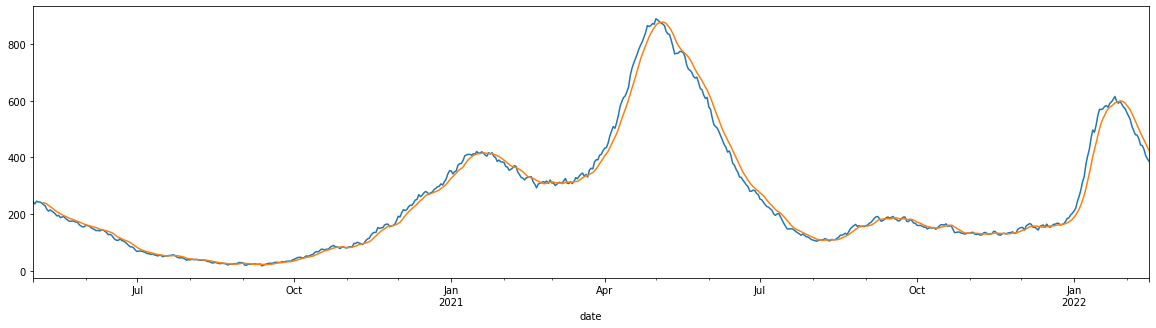

In [82]:
#moving weekly average, showing changes in the number of critical ICU patients per week, smoothing time series
critpatientdf['adult_icu_crci_patients'].plot(figsize=(20,5))
critpatientdf.rolling(window=7).mean()['adult_icu_crci_patients'].plot()

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

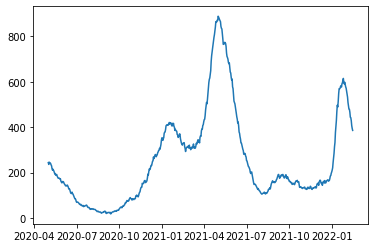

In [54]:
# plt.plot(critpatientdf)
plt.plot(critpatientdf["adult_icu_crci_patients"])

In [55]:
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
# adultcrit.head()
# type(adultcrit)

AttributeError: 'Figure' object has no attribute 'Subtitle'

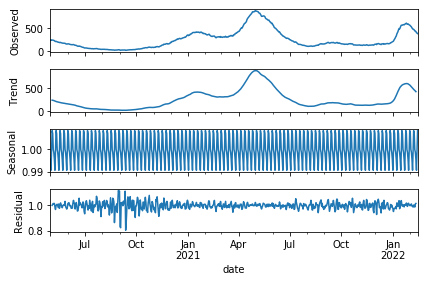

In [66]:
multi_adcrit = seasonal_decompose(adultcrit, model = "multiplicative")
multi_adcrit.plot().Subtitle('\n Multiplicative Decompose', fontsize = 12)

In [70]:
print(multi_adcrit)

In [67]:
# pd.DataFrame.multi_adcrit_new = ([multi_adcrit.seasonal, multi_adcrit.trend, multi_adcrit.resid, multi_adcrit.observed])
multi_adcrit_new = pd.DataFrame(multi_adcrit, columns=['Seasonality', 'Trend', 'Residual', 'Actual Values'])
# multi_adcrit_new.columns = ['Seasonality', 'Trend', 'Residual', 'Actual Values']
multi_adcrit_new.head

ValueError: DataFrame constructor not properly called!

In [ ]:
plt.plot(critpatientdf["ped_icu_crci_patients"])

In [31]:
# new = data.iloc[: , [0, 6, 7]].copy() 
# newdata = pd.Series([data.date, data.adult_icu_crci_patients, data.total_adult_icu_patients, data.ped_icu_crci_patients, data.total_ped_icu_patients]).transpose()


AttributeError: 'DataFrame' object has no attribute 'date'

In [10]:
# plt.plot(data[0:655]['adult_icu_crci_patients''available_adult_icu_beds''total_adult_icu_patients'])
# plt.xticks(rotation = 30)
# plt.show()

In [44]:
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
adultcrit.head()
type(adultcrit)

pandas.core.frame.DataFrame

In [11]:

# Code
# import pandas as pd
# from pandas import read_csv
# from patsy import dmatrices
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import statsmodels.discrete.discrete_model as sm
# from pylab import rcParams
# rcParams['figure.figsize'] = 20, 5
# #filepath ="C:\Users\Jneny\Desktop\820\datasets\icu_beds.csv"
# #dataset = pd.read_csv(filepath, header = 0, sep="," )
# ​
# data = read_csv(r"C:\Users\Jneny\Desktop\820\datasets\icu_beds.csv", header=0, parse_dates=[0], index_col=0, squeeze=True)
# print(type(data))
# data.info()
# #data.describe()
# data.head()
# #for x in data[]:
    
    
# data.describe(data['adult_icu_crci_patients'])
# plt.plot(data[0:655]['adult_icu_crci_patients'])
# plt.xticks(rotation = 30)
# plt.show()

# ​
